# Instacart Modeling

**Training, fine-tuning and testing a gradient boosting model on the entire Instacart dataset**  
**Note that this notebook is intended to be run on a cloud computing instance with postgresql database set up and stored with Instacart data**

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime
import patsy
import sys
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import psycopg2 as pg
import pandas.io.sql as pd_sql

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, log_loss, confusion_matrix, roc_curve, roc_auc_score

from helper_functions import plot_features, get_user_split_data

In [ ]:
# execute preprocessing python script
!python instacart_preprocessing.py

In [ ]:
# read pickled files
df_X = pd.read_pickle('data/df_X.pkl')
df_order_products_prior = pd.read_pickle('data/df_order_products_prior.pkl')
df_order_products_train = pd.read_pickle('data/df_order_products_train.pkl')
df_products = pd.read_pickle('data/df_products.pkl')
df_departments = pd.read_pickle('data/df_departments.pkl')
df_aisles = pd.read_pickle('data/df_aisles.pkl')

**Simple EDA:**

In [15]:
# count unique products in products dataframe
len(df_products.product_id.unique())

49688

In [13]:
# count unique products in main dataframe
len(df_X.product_id.unique())

49468

In [18]:
# count unique orders from prior
len(df_order_products_prior.order_id.unique())

3214874

In [12]:
# count unique users from main dataframe
len(df_X.user_id.unique())

131209

0    0.9022
1    0.0978
Name: in_cart, dtype: float64


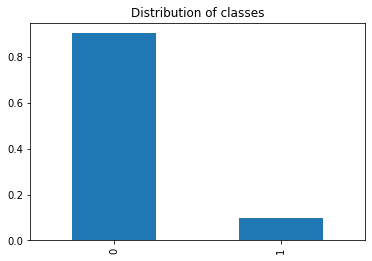

In [9]:
# plot distribution of classes (reordered vs not ordered)
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')
plt.title('Distribution of classes');

We can see the class imbalance here!  90% of products that wasn't re-ordered vs 10% that were

In [14]:
# info and head of dataframe
df_X.info()
df_X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 5 columns):
product_id                   object
user_id                      object
user_product_total_orders    int64
latest_cart                  object
in_cart                      int64
dtypes: int64(2), object(3)
memory usage: 387.9+ MB


,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,101093,1,"{22843, 23888}",0
1,11365,101093,1,"{22843, 23888}",0
2,12341,101093,1,"{22843, 23888}",0
3,16283,101093,2,"{22843, 23888}",0
4,17634,101093,1,"{22843, 23888}",0


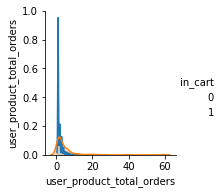

In [10]:
# plot pairplot on features
plot_features(df_X)

# Model training w/ Feature engineering

**Train and fit the xgboost model:**

In [19]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7 
                       )

eval_set = [(X_train,y_train),(X_val,y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

Baseline score of xgboost:

In [20]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.029159994348153733

## Product features
* Total count of orders across all users
* Average add_to_cart_order
* Probability of reorder relative to total order volume

In [21]:
# create product-specific features
prod_features = ['product_total_orders', 'product_avg_add_to_cart_order', 'product_reorder_prob']

df_prod_features = df_order_products_prior.groupby(['product_id'], as_index=False).agg(
    {'order_id': 'nunique', 'add_to_cart_order': 'mean', 'reordered': 'mean'})
df_prod_features.columns = ['product_id'] + prod_features
df_prod_features.head()

,product_id,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob
0,1,1852,5.801836,0.613391
1,10,2572,8.816874,0.506998
2,100,437,10.098398,0.560641
3,1000,2610,9.503448,0.408046
4,10000,11,6.454545,0.363636


In [22]:
# merge product-specific features with df x
df_X = df_X.merge(df_prod_features, on='product_id')
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391
1,1,10113,1,{30365},0,1852,5.801836,0.613391
2,1,101552,2,"{10690, 28371, 12481, 44070, 350, 36472, 19514...",0,1852,5.801836,0.613391
3,1,101727,6,"{21873, 11759, 18615, 38928, 45051, 43352}",0,1852,5.801836,0.613391
4,1,101806,1,"{130, 33452, 46041, 1648, 16953}",0,1852,5.801836,0.613391


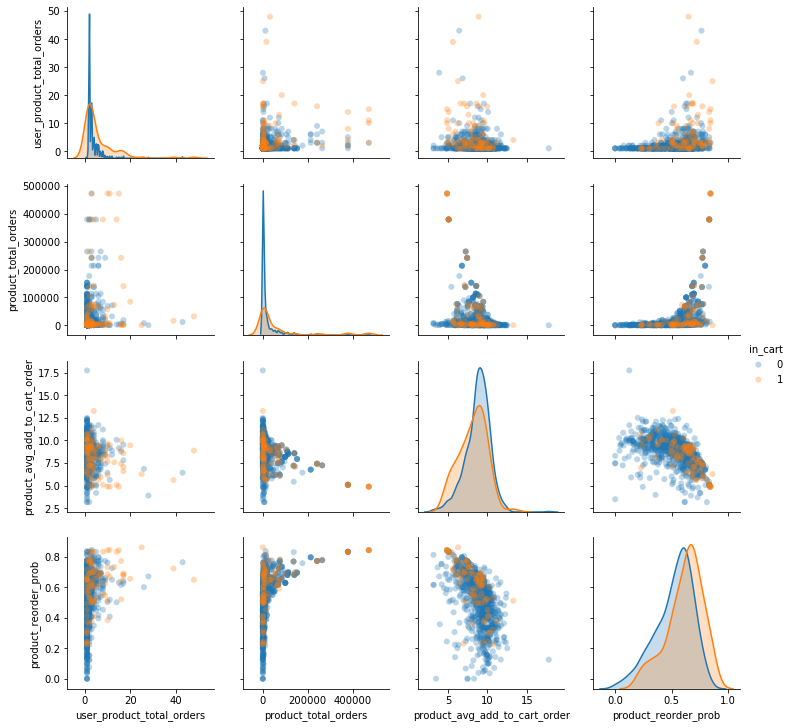

In [19]:
# plot pairplot of features
plot_features(df_X)

In [15]:
# info of df x
df_X.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 8 columns):
product_id                       object
user_id                          object
user_product_total_orders        int64
latest_cart                      object
in_cart                          int64
product_total_orders             int64
product_avg_add_to_cart_order    float64
product_reorder_prob             float64
dtypes: float64(2), int64(3), object(3)
memory usage: 581.9+ MB


In [23]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7 
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

In [24]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.04636827208584874

## User features
* Total # of orders
* Average cart size
* Average # of days since prior order
* Probability of reordering 

In [25]:
# convert datatype of some features
df_order_products_prior['days_since_prior_order'] = pd.to_numeric(df_order_products_prior['days_since_prior_order'], errors='coerce')

df_order_products_prior.order_number = df_order_products_prior.order_number.astype(int)
df_order_products_prior.reordered = df_order_products_prior.reordered.astype(int)
df_order_products_prior.order_dow = df_order_products_prior.order_dow.astype(int)
df_order_products_prior.order_hour_of_day = df_order_products_prior.order_hour_of_day.astype(int)

In [26]:
# create user-specific features
user_features = ['user_total_orders', 'user_avg_cart_size', 'user_avg_days_since_prior', 'user_reorder_prob']

df_user_features = df_order_products_prior.groupby('user_id', as_index=False).agg({
    'order_id':['nunique', lambda x: x.shape[0]/x.nunique()],
    'days_since_prior_order':'mean',
    'reordered':'mean'})

df_user_features.columns = ['user_id'] + user_features
df_user_features.head()

,user_id,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob
0,1,10,5.900000,20.259259,0.694915
1,10,5,28.600000,20.746377,0.342657
2,100,5,5.400000,26.320000,0.259259
3,1000,7,14.714286,11.647727,0.689320
4,10000,72,15.166667,4.949580,0.765568


In [27]:
# merge user-specific features with df x
df_X = df_X.merge(df_user_features, on = 'user_id')
df_X = df_X.dropna()
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,7.8,0.425
1,11365,101093,1,"{22843, 23888}",0,4337,3.795942,0.637537,6,6.666667,7.8,0.425
2,12341,101093,1,"{22843, 23888}",0,50221,5.255610,0.744011,6,6.666667,7.8,0.425


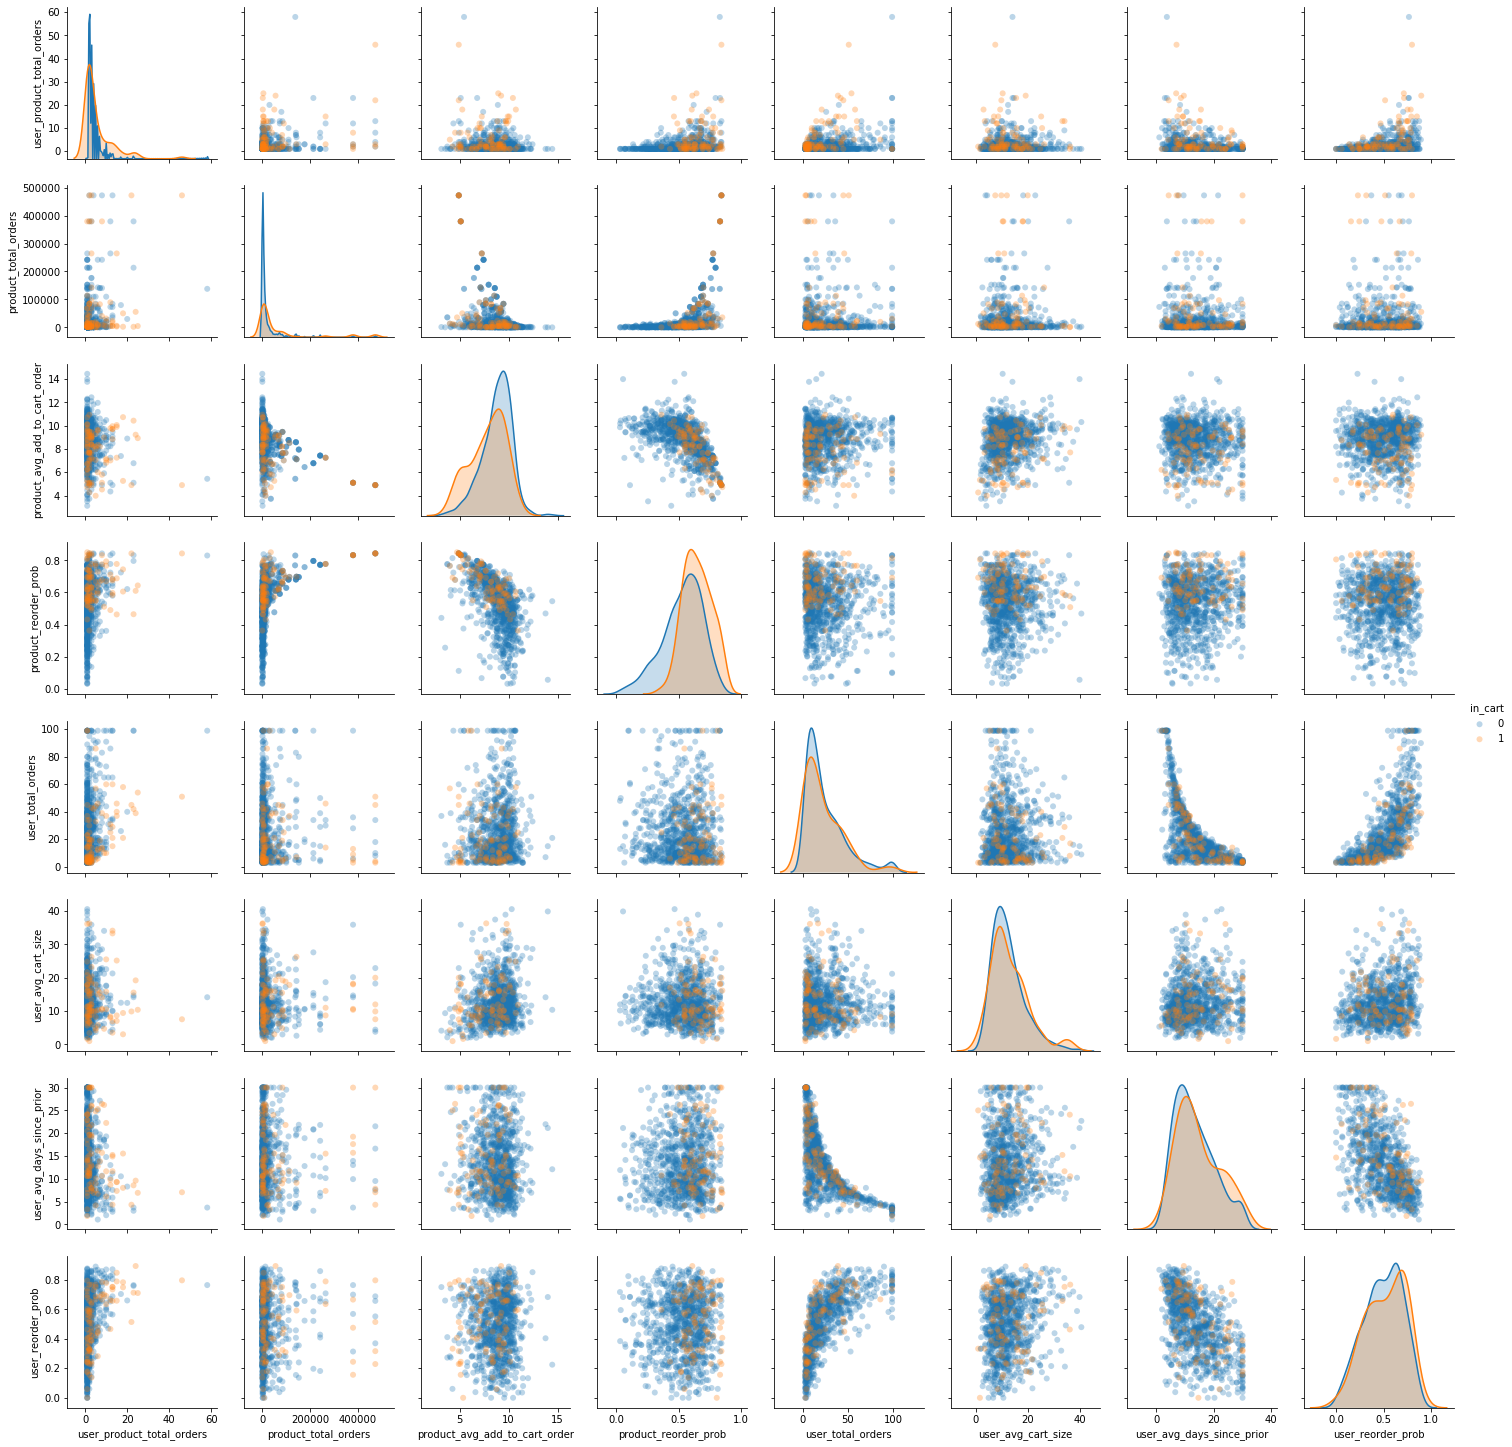

In [26]:
# plot pairplot of features
plot_features(df_X)

In [28]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7 
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

In [29]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.20209231889407445

## User-Product features
* Number of orders with the product for a user
* Probability of product in an order for a user
* Average days since prior purchase of product by user
* Average add to cart order of product by user 
* Average day of week of product purchased by user
* Average hour of day of product purchased by user
* Product purchased by user in the previous order
* Product purchased by user two orders ago
* Product purchased by user three orders ago
* Product purchased by user in each of the previous three orders
* Product purchased by user in at least one of the previous three orders

In [32]:
# create user-product-specific features
user_prod_features = ['user_product_reorder_prob',
                         'user_product_avg_days_since_last_order',
                         'user_product_avg_add_to_cart_order',
                         'user_product_order_dow',
                         'user_product_order_hour_of_day']

df_user_prod_features = df_order_products_prior.groupby(
    ['user_id', 'product_id'], as_index=False).agg({'reordered':'mean',
                                                       'days_since_prior_order':'mean',
                                                       'add_to_cart_order':'mean',
                                                       'order_dow':'mean',
                                                       'order_hour_of_day':'mean'})

df_user_prod_features.columns = ['user_id', 'product_id'] + user_prod_features
df_user_prod_features.head(3)

,user_id,product_id,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day
0,1,10258,0.888889,19.555556,3.333333,2.555556,10.555556
1,1,10326,0.000000,28.000000,5.000000,4.000000,15.000000
2,1,12427,0.900000,19.555556,3.300000,2.500000,10.300000


In [33]:
# merge user-product-specific features with df x
df_X = df_X.merge(df_user_prod_features, on = ['user_id', 'product_id'])
df_X = df_X.dropna()
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,7.8,0.425,0.0,2.0,7.0,4.0,21.0
1,11365,101093,1,"{22843, 23888}",0,4337,3.795942,0.637537,6,6.666667,7.8,0.425,0.0,21.0,5.0,4.0,20.0
2,12341,101093,1,"{22843, 23888}",0,50221,5.255610,0.744011,6,6.666667,7.8,0.425,0.0,7.0,1.0,4.0,21.0


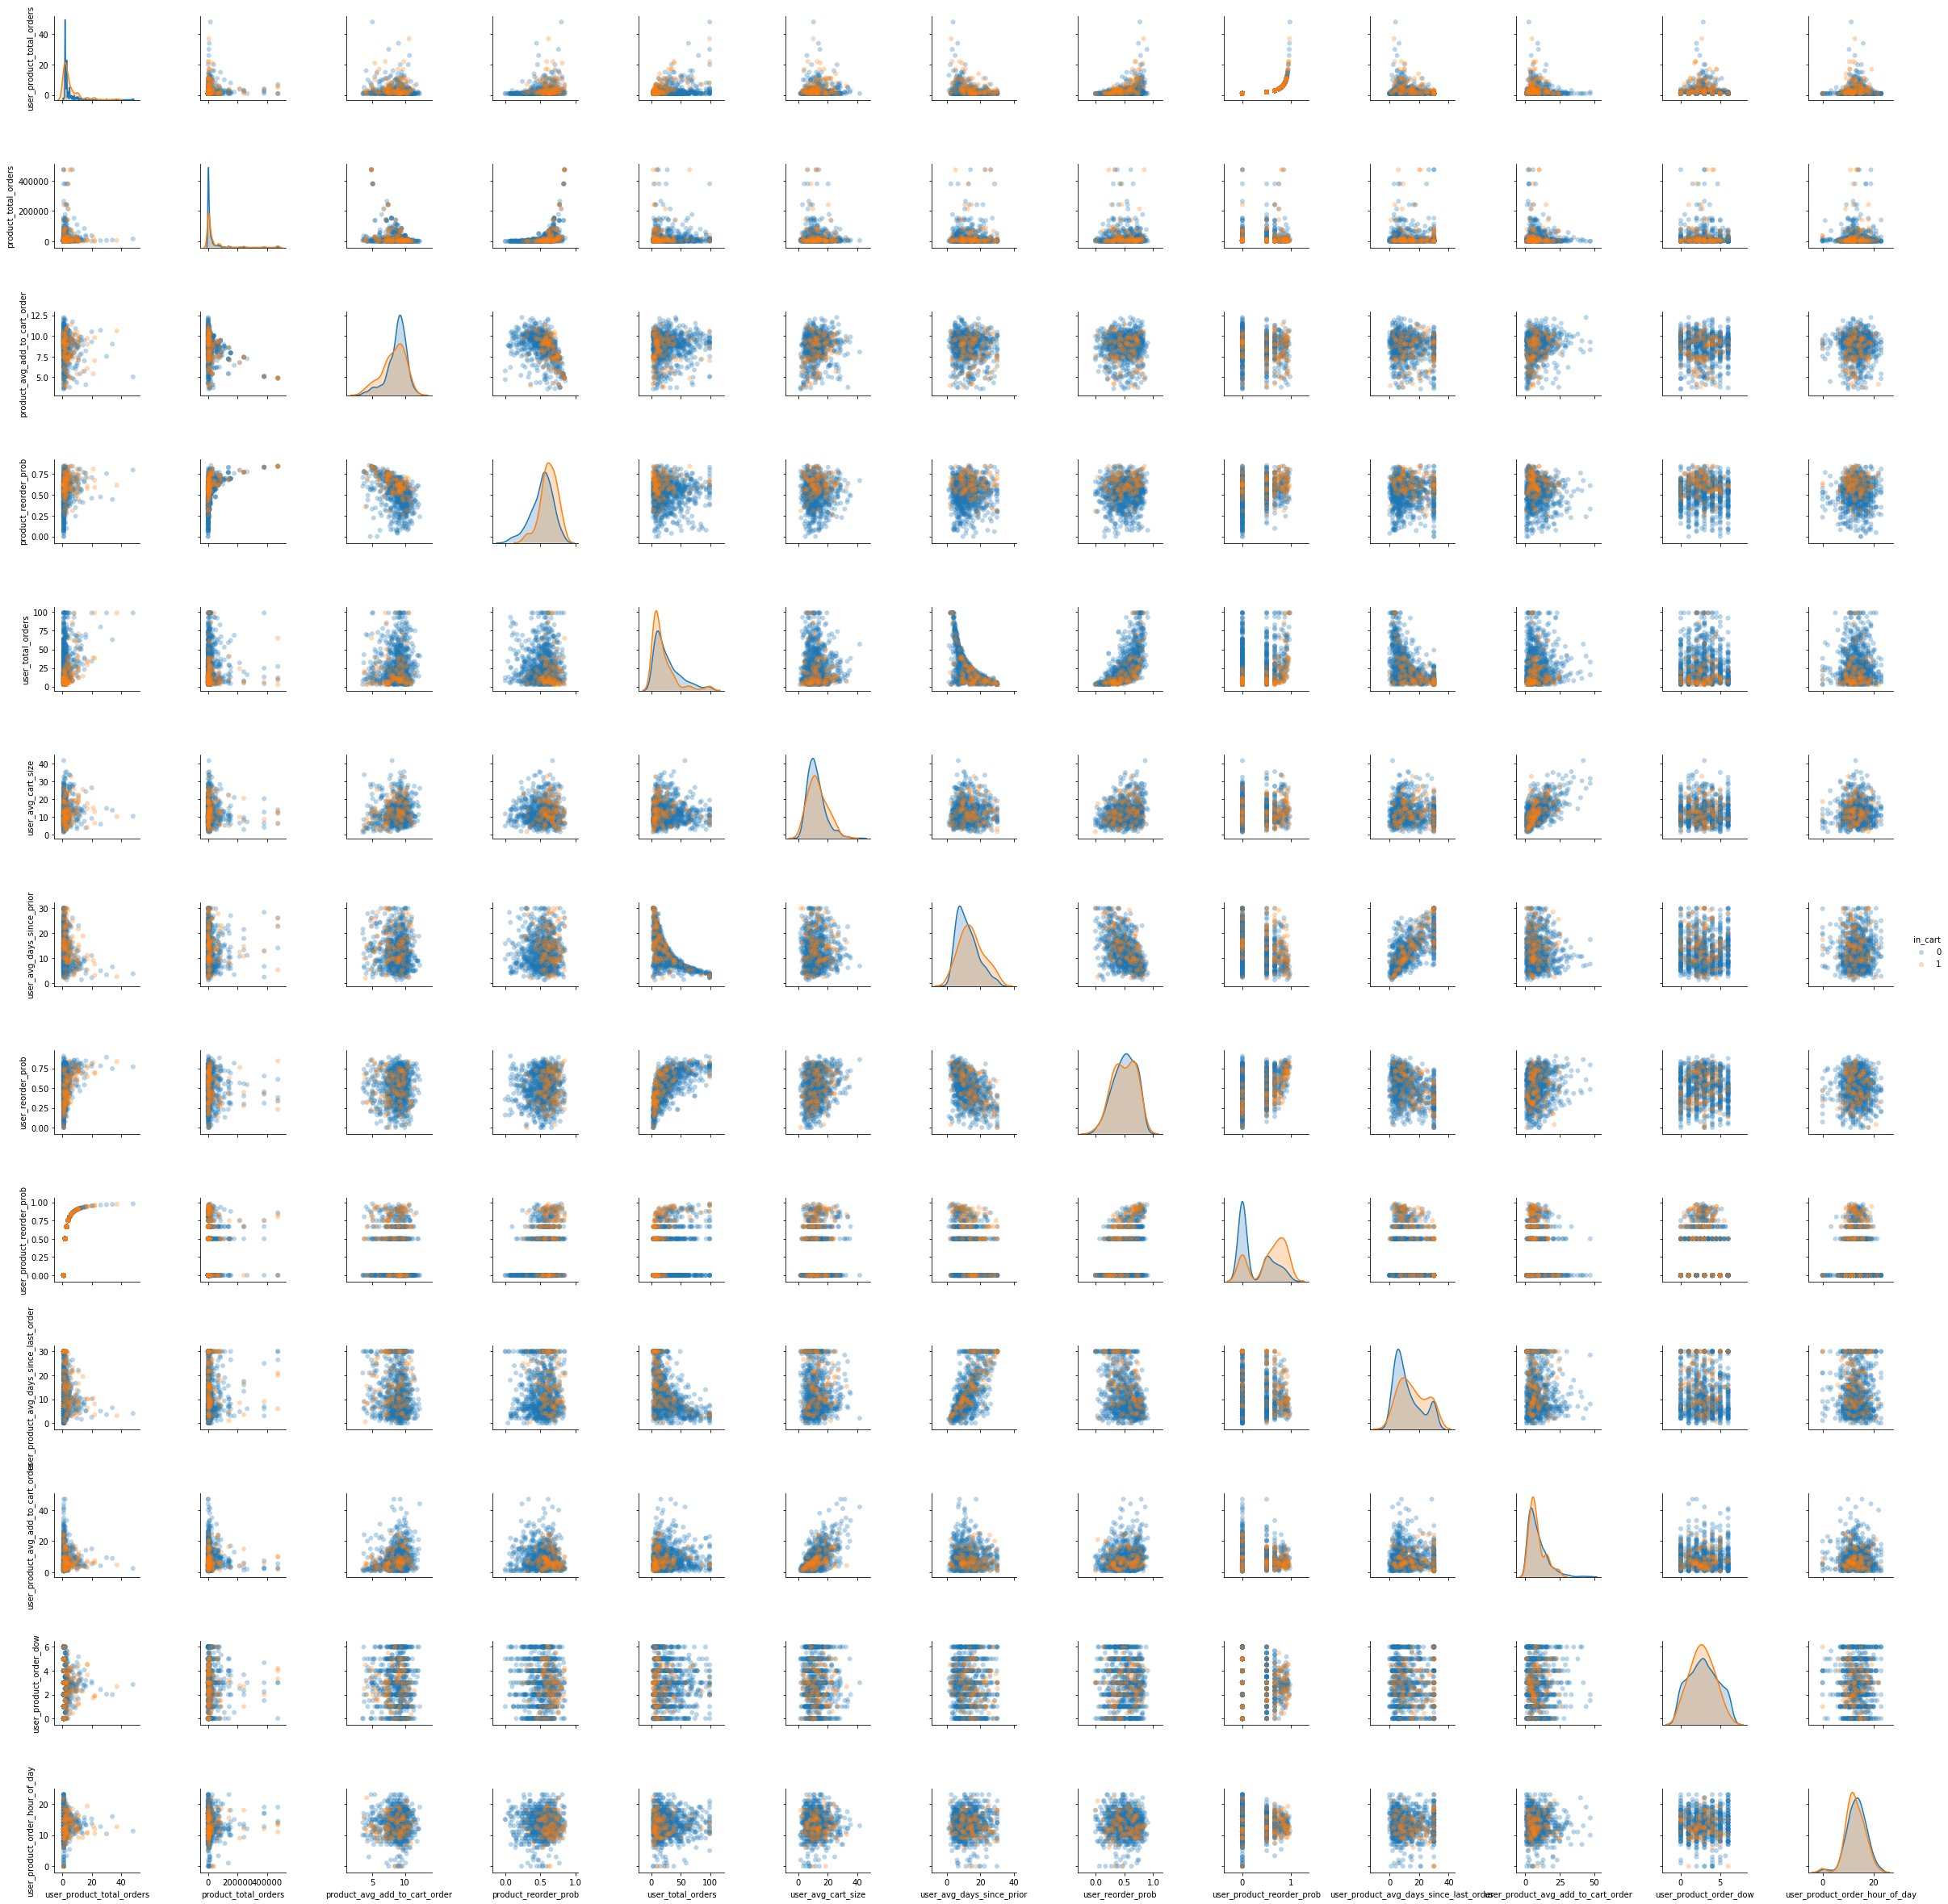

In [29]:
# plot pairplot of features
plot_features(df_X)

In [34]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

In [35]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.21070718920134054

In [36]:
#get max order number for customer in prior orders
max_order_number_prior = df_order_products_prior.groupby(
    ['user_id'], as_index=False).agg({'order_number':'max'}).rename(columns={'order_number':'max_order_number_prior'})

df_user_prod_features_recent = df_order_products_prior.merge(max_order_number_prior, on='user_id')

In [37]:
# head of user prod features recent df
df_user_prod_features_recent.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,max_order_number_prior
0,62,10017,1,0,189943,prior,4,0,11,7.0,10
1,62,43394,2,1,189943,prior,4,0,11,7.0,10
2,62,37766,3,1,189943,prior,4,0,11,7.0,10
3,62,26209,4,0,189943,prior,4,0,11,7.0,10
4,62,47766,5,0,189943,prior,4,0,11,7.0,10


In [38]:
# product purchased by user in the previous order (max order number in prior set)
df_user_prod_features_recent['user_product_in_one_order_ago'] = np.where(
    df_user_prod_features_recent['max_order_number_prior'] - 
    df_user_prod_features_recent['order_number'] == 0, 1, 0)

# product purchased by user two orders ago
df_user_prod_features_recent['user_product_in_two_orders_ago'] = np.where(
    df_user_prod_features_recent['max_order_number_prior'] - 
    df_user_prod_features_recent['order_number'] == 1, 1, 0)

# product purchased by user three orders ago
df_user_prod_features_recent['user_product_in_three_orders_ago'] = np.where(
    df_user_prod_features_recent['max_order_number_prior'] - 
    df_user_prod_features_recent['order_number'] == 2, 1, 0)

In [39]:
# aggregate by user and product
df_user_prod_features_recent = df_user_prod_features_recent.groupby(
    ['user_id', 'product_id'], as_index=False).agg({'user_product_in_one_order_ago':'max',
                                                   'user_product_in_two_orders_ago':'max',
                                                   'user_product_in_three_orders_ago':'max'})

# product purchased by user in all previous three orders
df_user_prod_features_recent['user_product_in_all_previous_three_orders'] = np.where(
    (df_user_prod_features_recent['user_product_in_one_order_ago'] == 1) &
    (df_user_prod_features_recent['user_product_in_two_orders_ago'] == 1) &
    (df_user_prod_features_recent['user_product_in_three_orders_ago'] == 1),  1, 0)

# product purchased by user in at least one of previous three orders
df_user_prod_features_recent['user_product_in_at_least_one_of_previous_three_orders_ago'] = np.where(
    (df_user_prod_features_recent['user_product_in_one_order_ago'] == 1) |
    (df_user_prod_features_recent['user_product_in_two_orders_ago'] == 1) |
    (df_user_prod_features_recent['user_product_in_three_orders_ago'] == 1),  1, 0)

In [40]:
# head of user prod features recent df
df_user_prod_features_recent.head(5)

,user_id,product_id,user_product_in_one_order_ago,user_product_in_two_orders_ago,user_product_in_three_orders_ago,user_product_in_all_previous_three_orders,user_product_in_at_least_one_of_previous_three_orders_ago
0,1,10258,1,1,1,1,1
1,1,10326,0,0,0,0,0
2,1,12427,1,1,1,1,1
3,1,13032,1,0,0,0,1
4,1,13176,0,0,0,0,0


In [41]:
# merge user prod features recent with df x
df_X = df_X.merge(df_user_prod_features_recent, on=['user_id', 'product_id'])
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day,user_product_in_one_order_ago,user_product_in_two_orders_ago,user_product_in_three_orders_ago,user_product_in_all_previous_three_orders,user_product_in_at_least_one_of_previous_three_orders_ago
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,...,0.0,2.0,7.0,4.0,21.0,1,0,0,0,1
1,11365,101093,1,"{22843, 23888}",0,4337,3.795942,0.637537,6,6.666667,...,0.0,21.0,5.0,4.0,20.0,0,0,1,0,1
2,12341,101093,1,"{22843, 23888}",0,50221,5.255610,0.744011,6,6.666667,...,0.0,7.0,1.0,4.0,21.0,0,0,0,0,0


In [42]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7 
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

In [43]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.2808835060376129

**F1 score of 0.28088 with 18 features**

## Department features

**Add department information as categorical features**

In [61]:
# merge product, department and aisle dataframes 
df_prod_dept_aisle = df_products.merge(df_departments, on='department_id')
df_prod_dept_aisle = df_prod_dept_aisle.merge(df_aisles, on='aisle_id')

In [50]:
# head of prod dept aisle df
df_prod_dept_aisle.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


In [55]:
# merge department with df x as categorical features
df_X = df_X.merge(df_prod_dept_aisle[['department', 'product_id']], on='product_id')
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day,user_product_in_one_order_ago,user_product_in_two_orders_ago,user_product_in_three_orders_ago,user_product_in_all_previous_three_orders,user_product_in_at_least_one_of_previous_three_orders_ago,department,aisle
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,...,7.0,4.0,21.0,1,0,0,0,1,snacks,cookies cakes
1,1,10113,1,{30365},0,1852,5.801836,0.613391,11,2.090909,...,5.0,4.0,18.0,0,0,0,0,0,snacks,cookies cakes
2,1,101552,2,"{10690, 28371, 12481, 44070, 350, 36472, 19514...",0,1852,5.801836,0.613391,8,13.750000,...,8.0,2.0,14.0,0,0,0,0,0,snacks,cookies cakes


In [65]:
# dummify department feature
df_X = pd.get_dummies(df_X, prefix=['dept'], columns=['department']) #, drop_first=True)
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,dept_household,dept_international,dept_meat seafood,dept_missing,dept_other,dept_pantry,dept_personal care,dept_pets,dept_produce,dept_snacks
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,...,0,0,0,0,0,0,0,0,0,1
1,1,10113,1,{30365},0,1852,5.801836,0.613391,11,2.090909,...,0,0,0,0,0,0,0,0,0,1
2,1,101552,2,"{10690, 28371, 12481, 44070, 350, 36472, 19514...",0,1852,5.801836,0.613391,8,13.750000,...,0,0,0,0,0,0,0,0,0,1


In [66]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7 
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

In [67]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.2796567658039185

**F1 score of 0.27965 with 39 features (including department)**

## Aisle features

**Add aisle information as categorical features**

In [68]:
# merge aisle into df_X as categorical features
df_X = df_X.merge(df_prod_dept_aisle[['aisle', 'product_id']], on='product_id')
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,dept_international,dept_meat seafood,dept_missing,dept_other,dept_pantry,dept_personal care,dept_pets,dept_produce,dept_snacks,aisle
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,...,0,0,0,0,0,0,0,0,1,cookies cakes
1,1,10113,1,{30365},0,1852,5.801836,0.613391,11,2.090909,...,0,0,0,0,0,0,0,0,1,cookies cakes
2,1,101552,2,"{10690, 28371, 12481, 44070, 350, 36472, 19514...",0,1852,5.801836,0.613391,8,13.750000,...,0,0,0,0,0,0,0,0,1,cookies cakes


In [69]:
# dummify aisle feature
df_X = pd.get_dummies(df_X, prefix=['aisle'], columns=['aisle']) #, drop_first=True)
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,1,101093,1,"{22843, 23888}",0,1852,5.801836,0.613391,6,6.666667,...,0,0,0,0,0,0,0,0,0,0
1,1,10113,1,{30365},0,1852,5.801836,0.613391,11,2.090909,...,0,0,0,0,0,0,0,0,0,0
2,1,101552,2,"{10690, 28371, 12481, 44070, 350, 36472, 19514...",0,1852,5.801836,0.613391,8,13.750000,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, 
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, 
                        min_child_weight = 12, 
                        colsample_bytree = 0.7 
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

In [71]:
# f1 score on validation set
f1_score(gb.predict(X_val), y_val) 

0.2802508788711896

**F1 score of 0.28025 with 173 features (including department)**

**At this point, because the F1 score is about the same when adding in department and aisle info versus leaving them out, we'll proceed to exclude those and use the product / user features only**

# Fine-tuning model

In [85]:
# use product/user features only (exclude department and aisle features)
df_X = df_X.iloc[:,:22]

## Fine-tuning hyperparameters of model
* Tune max_depth
* Tune subsample
* Tune min_child_weight
* Tune colsample_bytree
* Set learning_rate to .05 and use early stopping to get n_estimators

In [100]:
# split into train/val/test and train xgboost model
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

gb = xgb.XGBClassifier( 
                        n_estimators = 30000,
                        max_depth = 8, #10-0.242, 3-0.241, 9-0.246 8-0.280
                        objective = 'binary:logistic', 
                        learning_rate = 0.05, 
                        subsample = 0.8, #1-0.255, 0.9-0.251, 0.8-0.243, 0.5-0.246
                        min_child_weight = 12, #1-0.251, 5-0.260, 10-0.261, 15-0.260, #12-0.263
                        colsample_bytree = 0.7 #0.8-0.242, 0.5-0.253, 0.7-0.254
                       )

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'logloss', 
                    early_stopping_rounds = 50,
                    verbose = False
                   )

y_pred = gb.predict(X_val, ntree_limit = gb.best_ntree_limit)
f1_score(y_val, y_pred)

0.2794843419621912

## Handling class imbalance with decision threshold adjustment

Gradient Boosting Model with max F1 score 0.43928 at prob decision threshold >= 0.220


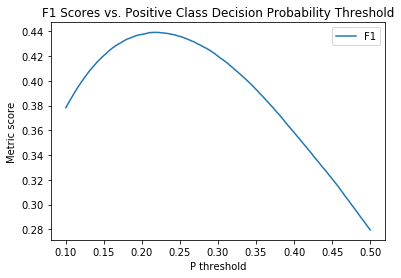

In [127]:
# calculate and plot f1 score from xgboost model across decision probability threshold values
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = gb.predict_proba(X_val, ntree_limit = gb.best_ntree_limit)[:,1]

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)

plt.title('F1 Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1']) 
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

plt.savefig('F1 curve.png')

print('Gradient Boosting Model with max F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

**Best F1 score, using 18 features, of 0.43928 at threshold >= 0.220**

Metrics when decision threshold is set at 0.220:

In [119]:
# calculate evaluation metrics
y_pred = (gb.predict_proba(X_val, ntree_limit=gb.best_ntree_limit)[:,1] >= 0.220).astype(int) 

f_score = f1_score(y_val, y_pred)
logloss_score = log_loss(y_val, y_pred)
prec_score = precision_score(y_val, y_pred)
rec_score = recall_score(y_val, y_pred)
acc_score = accuracy_score(y_val, y_pred)

print("Gradient Boosting performance:")
print("F1: {:6.5f}".format(f_score)) 
print("Log-loss: {:6.5f}".format(logloss_score)) 
print("Precision: {:6.5f}".format(prec_score))
print("Recall: {:6.5f}".format(rec_score))
print("Accuracy: {:6.5f}".format(acc_score))

Gradient Boosting performance:
F1: 0.43922
Log-loss: 4.44495
Precision: 0.39394
Recall: 0.49628
Accuracy: 0.87131


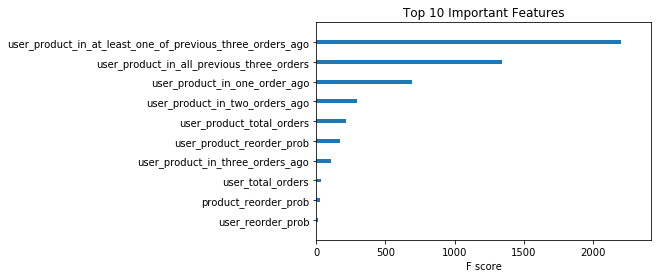

In [107]:
# plot important features
xgb.plot_importance(gb, importance_type='gain', max_num_features=10, grid=False, title='Top 10 Important Features', ylabel=None, show_values=False);

In [108]:
# extract raw gain scores
gb.get_booster().get_score(importance_type='gain') 

{'user_product_in_all_previous_three_orders': 1340.2963326084046,
 'user_product_in_at_least_one_of_previous_three_orders_ago': 2196.95285943331,
 'user_product_total_orders': 212.8615662681788,
 'user_total_orders': 36.94433777742563,
 'product_total_orders': 11.649542269248109,
 'product_avg_add_to_cart_order': 11.399906415909053,
 'user_product_avg_add_to_cart_order': 8.400313720813191,
 'user_product_avg_days_since_last_order': 9.60486915178946,
 'user_product_order_dow': 7.884477606684822,
 'user_product_in_three_orders_ago': 108.9119630563724,
 'user_product_in_two_orders_ago': 290.9197230015854,
 'product_reorder_prob': 30.131546618037103,
 'user_reorder_prob': 12.24056927487548,
 'user_avg_days_since_prior': 10.122162713726329,
 'user_avg_cart_size': 8.783936778499323,
 'user_product_order_hour_of_day': 6.62115521256525,
 'user_product_in_one_order_ago': 694.2964728538248,
 'user_product_reorder_prob': 169.38124761295538}

Logistic Regression Model best F1 score 0.44042 at prob decision threshold >= 0.231


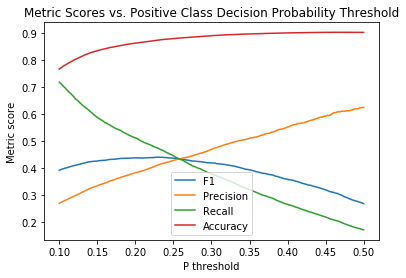

In [177]:
# calculate and plot evaluation metrics of xgboost model across probability threshold values
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = gb.predict_proba(X_val, ntree_limit = gb.best_ntree_limit)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Gradient Boost Model with best F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

plt.savefig('Metric scores.png')

ROC AUC score =  0.8259715207506582


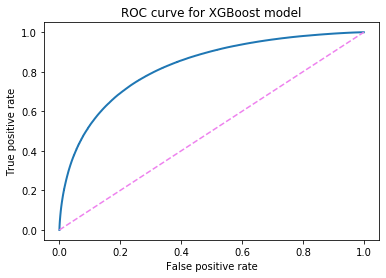

In [72]:
# calculate and plot roc curve
fpr, tpr, thresholds = roc_curve(y_val, gb.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for XGBoost model')
print("ROC AUC score = ", roc_auc_score(y_val, gb.predict_proba(X_val)[:,1]))

plt.savefig('ROC AUC score.png')

# Predictions on test set

In [109]:
# f1 score on held-out test set
y_pred_final = (gb.predict_proba(X_test, ntree_limit=gb.best_ntree_limit)[:,1] >= 0.220).astype(int) 
f1_score(y_test, y_pred_final)

0.4399662439834299

In [122]:
# evaluation metrics on test set
f_score = f1_score(y_test, y_pred_final)
logloss_score = log_loss(y_test, y_pred_final)
prec_score = precision_score(y_test, y_pred_final)
rec_score = recall_score(y_test, y_pred_final)
acc_score = accuracy_score(y_test, y_pred_final)
auc_score = roc_auc_score(y_test, y_pred_final)

print("Gradient Boosting performance:")
print("F1: {:6.5f}".format(f_score)) 
print("Log-loss: {:6.5f}".format(logloss_score)) 
print("Precision: {:6.5f}".format(prec_score))
print("Recall: {:6.5f}".format(rec_score))
print("Accuracy: {:6.5f}".format(acc_score))
print("ROC AUC: {:6.5f}".format(auc_score))

Gradient Boosting performance:
F1: 0.43997
Log-loss: 4.44256
Precision: 0.39323
Recall: 0.49930
Accuracy: 0.87138
ROC AUC: 0.70628


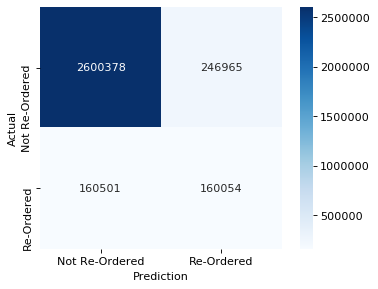

In [124]:
# function to create and plot confusion matrix
def make_confusion_matrix(model, threshold=0.220):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict_final = (model.predict_proba(X_test, ntree_limit = gb.best_ntree_limit)[:, 1] >= threshold)
    insta_confusion = confusion_matrix(y_test, y_predict_final)
    plt.figure(dpi=80)
    sns.heatmap(insta_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Re-Ordered', 'Re-Ordered'],
           yticklabels=['Not Re-Ordered', 'Re-Ordered']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

make_confusion_matrix(gb)

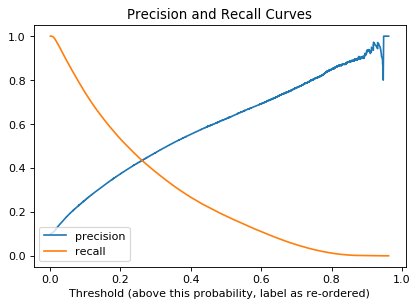

In [125]:
# we can also use the probabilities to make a curve showing us how recall and thresholds trade off 
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, gb.predict_proba(X_test, ntree_limit=gb.best_ntree_limit)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as re-ordered)');
plt.title('Precision and Recall Curves');

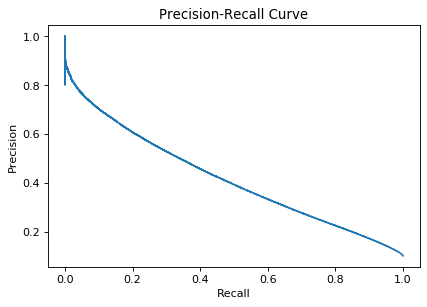

In [126]:
# plot precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

## Error Analysis on predictions from test data 

In [ ]:
# create new dataframe that joins together the original df_X with our y predictions (non-predicted rows will be excluded in the new dataframe)
df_X_pred_final = df_X.iloc[X_test.index]
df_X_pred_final['prediction'] = y_pred_final

In [ ]:
# add a column that outputs whether our prediction matches with actual target
df_X_pred['prediction_matches'] = np.where(df_X_pred.in_cart == df_X_pred.prediction, 1, 0)

In [ ]:
# merge in department, aisle and product name for more details
df_X_pred = df_X_pred.merge(df_prod_dept_aisle[[
                            'product_name', 'department', 'aisle', 'product_id']], on='product_id')

In [ ]:
# check out what we predicted wrong on a random user
df_X_pred[df_X_pred.user_id == '15182']